# Stochastic Computer Models
## MSE and efficiency line plots

In [9]:
import seaborn as sns
import chaospy as chaospy
import numpy as np
import numpy.random as R
import matplotlib.pyplot as plt
from scipy.special import comb
import time
import pandas as pd
import global_as
from matplotlib.pyplot import MultipleLocator

In [2]:
### Define general functions for AS method and PCE approach
epsilon = 0.001
def dFunc(x):
    chi, dim = x.shape[0], x.shape[1]
    xe = np.tile(x.transpose(), dim).transpose()+np.repeat(np.array(np.identity(dim)*epsilon), chi, axis=0)
    return ((Func(xe)-np.tile(Func(x),dim))/epsilon).reshape(dim,chi)

def Phi_est(X, expo, coef):
    Num = X.shape[0]
    return np.dot(np.prod((np.tile(X, P)**expo.flatten()).reshape((Num*P, dim)),axis = 1).reshape((Num, P))
               ,np.array(coef)).T

def estimate_k_reg(z, exponents, coefficients):   
    phi = Phi_est(z, exponents, coefficients)
    khat = np.linalg.inv(phi @ np.transpose(phi)) @ phi @ Func(z)
    return khat

def MSE(z):
        return np.mean((z-realprice)**2)

def Fun0(z,z1):
    dim1 = z.shape[1]
    f1 = Func(np.dot(z,u0[:,:dim1].transpose())+np.dot(z1,u0[:,dim1:].transpose()))
    return f1
    
def estimate_k_reg0(z,z1, exponents, coefficients):   
    phi = Phi_est(z, exponents, coefficients)
    khat = np.linalg.inv(phi @ np.transpose(phi)) @ phi @ Fun0(z,z1)
    return khat


In [3]:
#Asian option price with stochastic volatilities
dim = 10
chi = 10000
def Func(x1):
    chi = x1.shape[0]
    dim = x1.shape[1]
    s, v = np.zeros((chi, dim+1)),np.zeros((chi, dim+1))
    result = np.zeros(chi)
    for k in range(10):
        normal2 = R.normal(0, 1, (chi, dim))
        s[:,0] = S
        v[:,0] = V    
        for i in range(dim):
            vmax = np.maximum(v[:,i],0)
            s[:,i+1] = s[:,i] + r*s[:,i]/dim + s[:,i]*np.sqrt(vmax/dim)*x1[:,i]        
            v[:,i+1] = v[:,i] + sigma*np.sqrt(vmax/dim)*(rho*x1[:,i]+rho2*normal2[:,i])+ kapa*(theta-vmax)/dim 
        result += np.exp(-r)*np.maximum(1/dim*s[:,1:].sum(axis=1)-100,0)
    return result/10

For each p, run the following codes to get MSE and efficiency data for the 4 methods: MC, PCE, AS_PCE and GAS_PCE.

In [22]:
S, r, V, kapa, theta = 100, 0.03,0.04,2,0.04
sigma = 0.09
rho = 0.9
M2 = 1
 
dim = 10
chi = 10000
rho2 = np.sqrt(1-rho**2)
realprice = 0
for i in range(10):
    z3 = R.normal(0, 1, (1000000, dim))
    realprice += np.mean(Func(z3))
realprice /= 10

#AS
epsilon = 0.001
z = R.normal(0, 1, (chi, dim))
start = time.time() 
R.normal(0, 1, (chi, dim))
deriv = dFunc(z)
deriv /= np.mean(abs(deriv))
u0, s0, vh0 = np.linalg.svd(deriv.astype(float), full_matrices=True) 
s0 = s0**2
end = time.time()   
time_as = end - start

#GAS
start = time.time() 
u, s = global_as.GAS(Func,dim,chi,int(chi/M2),M2,shiftedSobol=True)
end = time.time()   
time_gas = end - start




#Comparison
N = 10000
z0 = R.normal(0, 1, (N, dim))  
z1 = []
for i in range(40):
    z1.append(R.normal(0, 1, (N, dim)))
Num_exp = 40

#Before Reduction
p = 4
P = int(comb(p + dim, dim))

distribution = chaospy.J(chaospy.Normal(0, 1))
for i in range(dim-1):
    distribution = chaospy.J(distribution, chaospy.Normal(0, 1))
poly, norms = chaospy.generate_expansion(p, distribution, retall=True)
normalized_coefficients = poly.coefficients/np.sqrt(norms)

#MC and PCE
MC, PCE = np.zeros(Num_exp), np.zeros(Num_exp)
times = np.zeros(2)

for i in range(Num_exp):  
    start = time.time()    
    MC[i] = np.mean(Func(z1[i]))
    end = time.time()    
    times[0] += end - start
         
    start = time.time() 
    kii = estimate_k_reg(z1[i],poly.exponents,normalized_coefficients)
    PCE[i] = kii[0]
    end = time.time()
    times[1] += end - start
print(np.array([sigma,rho,times[0],MSE(MC),times[1],MSE(PCE)]))

#After Reduction
dim = np.where((np.cumsum(s)/np.sum(s))>0.75)[0][0]+1
P = int(comb(p + dim, dim))

distribution = chaospy.J(chaospy.Normal(0, 1))
for i in range(dim-1):
    distribution = chaospy.J(distribution, chaospy.Normal(0, 1))
poly, norms = chaospy.generate_expansion(p, distribution, retall=True)
normalized_coefficients = poly.coefficients/np.sqrt(norms)

#AS_PCE and GAS_PCE
PCE, PCE2 = np.zeros(Num_exp), np.zeros(Num_exp)
times = np.zeros(3)

times[0] += time_as
start = time.time() 
for i in range(Num_exp):           
    kii = estimate_k_reg0(z1[i][:,:dim],z1[i][:,dim:],poly.exponents,normalized_coefficients)
    PCE[i] = kii[0]
end = time.time()
times[0] += end - start

times[1] += time_gas
start = time.time() 
PCE2 = global_as.GAS_PCE(Func, Num_exp, z1, dim, u, poly.exponents, normalized_coefficients, P)
end = time.time()   
times[1] += end - start    

print(np.array([sigma,rho,times[0],MSE(PCE),times[1],MSE(PCE2)]))

[9.00000000e-02 9.00000000e-01 1.77009034e+00 4.98862620e-03
 6.10222406e+01 1.08418158e-04]
[9.00000000e-02 9.00000000e-01 3.79656911e+00 1.52165690e-03
 3.30268288e+00 1.16703471e-04]


Summarize the data from experiments, and we get the following plots.

[0.55574346 0.61209373 0.66593074 0.716915   0.7671312  0.81556022
 0.86331337 0.90980444 0.9554745  1.        ]
[0.92065644 0.94940615 0.96817379 0.98125762 0.98978001 0.99495857
 0.9978016  0.9992228  0.99980743 1.        ]


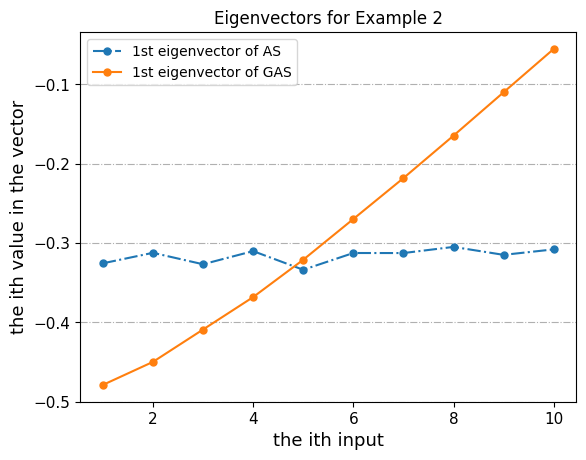

In [27]:
print(np.cumsum(s0)/np.sum(s0))
print(np.cumsum(s)/np.sum(s))

x=np.arange(1,1+10,1)
fig,ax=plt.subplots(figsize=(6.4,4.8), dpi=100)
colorc=plt.rcParams['axes.prop_cycle'].by_key()['color']
ax.plot(x,u0[:,0], label='1st eigenvector of AS', c=colorc[0], linestyle='-.', marker='.', markersize='10')
ax.plot(x,u[:,0], label='1st eigenvector of GAS', c=colorc[1], linestyle='-', marker='.', markersize='10')
ax.set_xlabel('the ith input', fontsize=13)
ax.set_ylabel('the ith value in the vector', fontsize=13)
ax.tick_params(axis='both', labelsize=11)
ax.yaxis.grid(True, linestyle='-.')

legend = ax.legend(loc='best')
plt.title('Eigenvectors for Example 2') 
plt.show()

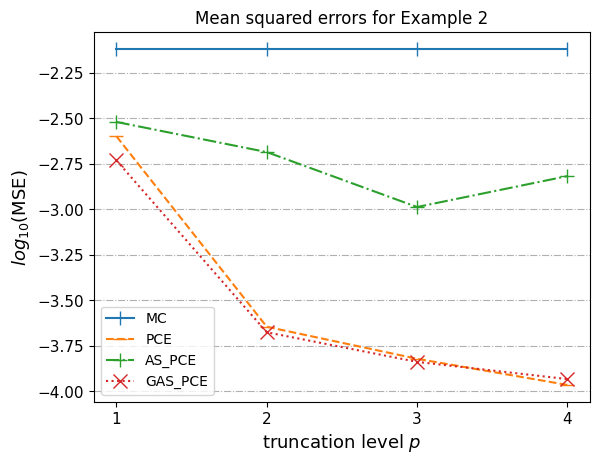

In [25]:
x=np.arange(1,5,1)
eMC = [0.00760662]*4#,7.75857391e-03,6.56614605e-03,4.98862620e-03]
ePCE = [0.00251828,2.26331707e-04,1.50876689e-04,1.08418158e-04]
ePCE_AS = [3.01918146e-03,2.06259574e-03,1.02946083e-03,1.52165690e-03]
ePCE_GAS = [1.85650336e-03,2.11047955e-04,1.45122600e-04,1.16703471e-04]

efMC = [1/(0.00760662*1.72982311)]*4 #[1/(0.00760662*1.72982311),1/(7.75857391e-03*1.85627341e+00),1/(6.56614605e-03*1.96044064e+00),1/(4.98862620e-03*1.77009034e+00)]
efPCE = [1/(0.00251828*2.29250932),1/(2.26331707e-04*5.28711891e+00),1/(1.50876689e-04*1.66162574e+01),1/(1.08418158e-04*6.10222406e+01)]
efPCE_AS = [1/(3.01918146e-03*3.07851005e+00),1/(2.06259574e-03*3.07147908e+00),1/(1.02946083e-03*3.06206894e+00),1/(1.52165690e-03*3.79656911e+00)]
efPCE_GAS = [1/(1.85650336e-03*3.38058662e+00),1/(2.11047955e-04*3.43521357e+00),1/(1.45122600e-04*3.43720174e+00),1/(1.16703471e-04*3.30268288e+00)]

fig,ax=plt.subplots(figsize=(6.4,4.8), dpi=100)
ax.plot(x,np.log10(eMC), label='MC', linestyle='-', marker='|', markersize='10')
ax.plot(x,np.log10(ePCE), label='PCE', linestyle='--', marker='_', markersize='10')
ax.plot(x,np.log10(ePCE_AS), label='AS_PCE', linestyle='-.', marker='+', markersize='10')
ax.plot(x,np.log10(ePCE_GAS), label='GAS_PCE', linestyle=':', marker='x', markersize='10')

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.set_xlabel('truncation level $p$', fontsize=13)
ax.set_ylabel('$log_{10}$(MSE)', fontsize=13)
ax.tick_params(axis='both', labelsize=11)
ax.yaxis.grid(True, linestyle='-.')

legend = ax.legend(loc='best')
plt.title('Mean squared errors for Example 2') 
plt.show()

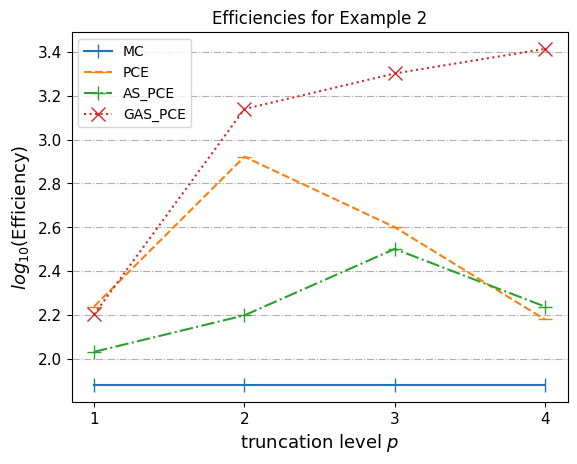

In [26]:
fig,ax=plt.subplots(figsize=(6.4,4.8), dpi=100)
ax.plot(x,np.log10(efMC), label='MC', linestyle='-', marker='|', markersize='10')
ax.plot(x,np.log10(efPCE), label='PCE', linestyle='--', marker='_', markersize='10')
ax.plot(x,np.log10(efPCE_AS), label='AS_PCE', linestyle='-.', marker='+', markersize='10')
ax.plot(x,np.log10(efPCE_GAS), label='GAS_PCE', linestyle=':', marker='x', markersize='10')

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.set_xlabel('truncation level $p$', fontsize=13)
ax.set_ylabel('$log_{10}$(Efficiency)', fontsize=13)
ax.tick_params(axis='both', labelsize=11)
ax.yaxis.grid(True, linestyle='-.')
legend = ax.legend(loc='best')
plt.title('Efficiencies for Example 2') 
plt.show()

## MSE and efficiency heat maps

In [16]:
adata = []
M2 = 100
S, r, V, kapa, theta = 100, 0.03, 0.025, 3, 0.025
for sigma in [0.01,0.05,0.1,0.15,0.2]:
    for rho in [-0.99,-0.9,-0.5,0,0.5,0.9,0.99]:
        dim = 10
        chi = 10000
        rho2 = np.sqrt(1-rho**2)
        realprice = 0
        for i in range(1):
            z3 = R.normal(0, 1, (1000000, dim))
            realprice += np.mean(Func(z3))
        realprice /= 1

        #AS
        epsilon = 0.001
        z = R.normal(0, 1, (chi, dim))
        start = time.time() 
        R.normal(0, 1, (chi, dim))
        deriv = dFunc(z)
        deriv /= np.mean(abs(deriv))
        u0, s0, vh0 = np.linalg.svd(deriv.astype(float), full_matrices=True) 
        s0 = s0**2
        end = time.time()   
        time_as = end - start

        #GAS
        start = time.time() 
        u, s = global_as.GAS(Func,dim,chi,int(chi/M2),M2,shiftedSobol=True)
        end = time.time()   
        time_gas = end - start

        #Comparison
        N = 10000
        z0 = R.normal(0, 1, (N, dim))  
        z1 = []
        for i in range(40):
            z1.append(R.normal(0, 1, (N, dim)))
        Num_exp = 40

        #After Reduction
        p = 3
        dim = np.where((np.cumsum(s)/np.sum(s))>0.75)[0][0]+1
        P = int(comb(p + dim, dim))

        distribution = chaospy.J(chaospy.Normal(0, 1))
        for i in range(dim-1):
            distribution = chaospy.J(distribution, chaospy.Normal(0, 1))
        poly, norms = chaospy.generate_expansion(p, distribution, retall=True)
        normalized_coefficients = poly.coefficients/np.sqrt(norms)

        #AS_PCE and GAS_PCE
        PCE, PCE2 = np.zeros(Num_exp), np.zeros(Num_exp)
        times = np.zeros(3)

        times[0] += time_as
        start = time.time() 
        for i in range(Num_exp):           
            kii = estimate_k_reg0(z1[i][:,:dim],z1[i][:,dim:],poly.exponents,normalized_coefficients)
            PCE[i] = kii[0]
        end = time.time()
        times[0] += end - start

        times[1] += time_gas
        start = time.time() 
        PCE2 = global_as.GAS_PCE(Func, Num_exp, z1, dim, u, poly.exponents, normalized_coefficients, P)
        end = time.time()   
        times[1] += end - start     
        
        adata.append([sigma,rho,times[0],MSE(PCE),times[1],MSE(PCE2)])

/Users/yrl192/Library/Python/3.9/lib/python/site-packages/scipy/stats/_qmc.py:763: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


In [17]:
adata = np.array(adata)
asEff = 1/(adata[:,2]*adata[:,3])
gasEff = 1/(adata[:,4]*adata[:,5])
errRatio = adata[:,5]/adata[:,3]
effRatio = gasEff/asEff

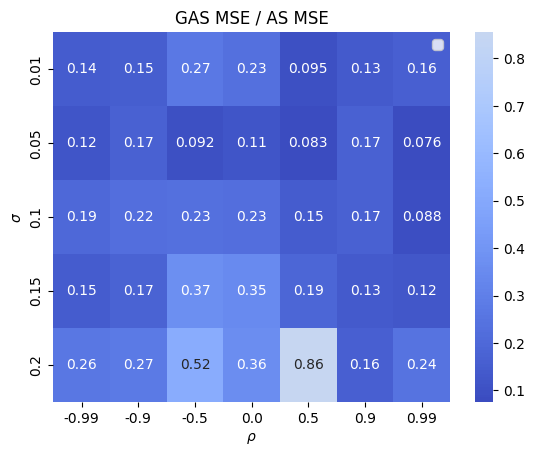

In [18]:
er = errRatio.reshape((5,7))
df = pd.DataFrame(er,columns=adata[:,1].reshape((5,7))[0,:],index=adata[:,0].reshape((5,7))[:,0])
sns.heatmap(df,cmap='coolwarm',annot=True,center = 1)
plt.title('GAS MSE / AS MSE')
plt.xlabel(r'$\rho$')
plt.ylabel(r'$\sigma$')
plt.legend()
plt.show() 

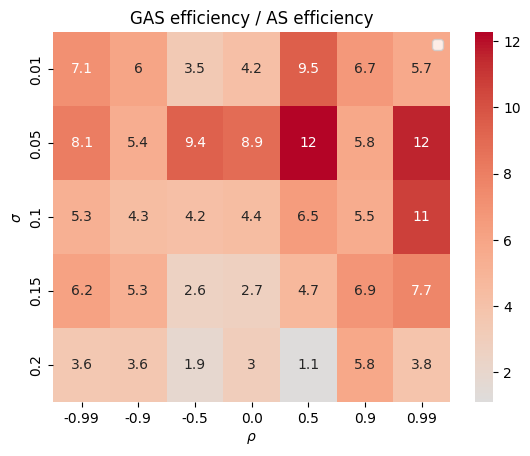

In [19]:
er = effRatio.reshape((5,7))
df = pd.DataFrame(er,columns=adata[:,1].reshape((5,7))[0,:],index=adata[:,0].reshape((5,7))[:,0])
sns.heatmap(df,cmap='coolwarm',annot=True,center = 1)
plt.title('GAS efficiency / AS efficiency')
plt.xlabel(r'$\rho$')
plt.ylabel(r'$\sigma$')
plt.legend()
plt.show() 